## Extreme Compression of LLMs for Edge Computing

This notebook demonstrates a complete pipeline for compressing large language models (LLMs) to make them deployable on edge devices:

1. **Fine-tuning** a teacher model (BERT-base) on text classification
2. **Knowledge Distillation** to a smaller student model (DistilBERT)
3. **Pruning** to remove low-importance weights
4. **Quantization** to reduce precision (FP32 → INT8)
5. **ONNX Conversion** for optimized inference
6. **ONNX Quantization** for further compression
7. **Benchmarking** at each compression stage

---


## 1. Setup and Installation


In [ ]:
# Set CUDA environment variable BEFORE importing torch
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Install required packages
!pip install -q transformers datasets accelerate evaluate scikit-learn matplotlib seaborn pandas torch torchvision torchaudio optimum[onnxruntime] onnx onnxruntime-gpu onnxruntime-extensions psutil

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
import torch
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Clear CUDA cache before setting seed
if torch.cuda.is_available():
    torch.cuda.empty_cache()

set_seed(42)

# Create directories for saving models
os.makedirs('/content/models', exist_ok=True)
os.makedirs('/content/models/teacher', exist_ok=True)
os.makedirs('/content/models/student', exist_ok=True)
os.makedirs('/content/models/pruned', exist_ok=True)
os.makedirs('/content/models/quantized', exist_ok=True)
os.makedirs('/content/models/onnx', exist_ok=True)

print("✅ Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ Setup complete!
PyTorch version: 2.8.0+cu126
CUDA available: True


## 2. Load Dataset (SST-2 Sentiment Classification)


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load SST-2 dataset (Stanford Sentiment Treebank)
dataset = load_dataset("glue", "sst2")

# Use smaller splits for faster training
train_dataset = dataset['train'].select(range(min(5000, len(dataset['train']))))
val_dataset = dataset['validation'].select(range(min(500, len(dataset['validation']))))
test_dataset = dataset['test'].select(range(min(1000, len(dataset['test']))))

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"\nExample:")
print(train_dataset[0])


Train samples: 5000
Validation samples: 500
Test samples: 1000

Example:
{'sentence': 'hide new secretions from the parental units ', 'label': 0, 'idx': 0}


In [ ]:
# Load tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

print("✅ Dataset tokenized and formatted!")


✅ Dataset tokenized and formatted!


## 3. Fine-tune Teacher Model (BERT-base)


In [ ]:
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from evaluate import load as load_metric
import torch.nn as nn

# Load teacher model
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    output_hidden_states=True  # Needed for distillation
)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model = teacher_model.to(device)
print(f"✅ Teacher model loaded on {device}")
print(f"Model parameters: {sum(p.numel() for p in teacher_model.parameters()) / 1e6:.2f}M")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Teacher model loaded on cuda
Model parameters: 109.48M


In [ ]:
training_args = TrainingArguments(
    output_dir="/content/models/teacher",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="/content/logs",
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=1,
)

# Metrics
metric = load_metric("glue", "sst2")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    labels = eval_pred.label_ids

    # If the model returns multiple outputs (e.g., logits, hidden_states),
    # predictions will be a tuple. We only care about the logits.
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Trainer
trainer = Trainer(
    model=teacher_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer),
)

print("🚀 Starting teacher model training...")
trainer.train()

# Evaluate
###---------------debut

# ============================================
# DEBUG: Check label compatibility
# ============================================
print("\n" + "="*60)
print("DEBUGGING LABEL MISMATCH")
print("="*60)

# Check model configuration
print(f"Model expects {teacher_model.config.num_labels} classes")
print(f"Model label mapping: {teacher_model.config.id2label if hasattr(teacher_model.config, 'id2label') else 'Not set'}")

# Check training data labels (from what was used in training)
train_labels = [item['label'] for item in train_dataset]
print(f"\nTRAIN labels - Min: {min(train_labels)}, Max: {max(train_labels)}")
print(f"TRAIN unique labels: {sorted(set(train_labels))}")

# Check validation data labels
val_labels = [item['label'] for item in val_dataset]
print(f"\nVAL labels - Min: {min(val_labels)}, Max: {max(val_labels)}")
print(f"VAL unique labels: {sorted(set(val_labels))}")

# Check test data labels
test_labels = [item['label'] for item in test_dataset]
print(f"\nTEST labels - Min: {min(test_labels)}, Max: {max(test_labels)}")
print(f"TEST unique labels: {sorted(set(test_labels))}")

# Find problematic labels in test set
num_labels = teacher_model.config.num_labels
invalid_test_labels = [label for label in test_labels if label < 0 or label >= num_labels]

if invalid_test_labels:
    print(f"\n❌ PROBLEM FOUND: {len(invalid_test_labels)} invalid labels in test set!")
    print(f"Invalid values: {sorted(set(invalid_test_labels))}")
    print(f"These labels are >= {num_labels} or < 0")

    # Show which indices have problems
    problem_indices = [i for i, label in enumerate(test_labels) if label < 0 or label >= num_labels]
    print(f"Problematic indices (first 10): {problem_indices[:10]}")
else:
    print("\n✅ All test labels are valid")

print("="*60 + "\n")

# ============================================
# Now evaluate (only if labels are valid)
# ============================================
if not invalid_test_labels:
    # Temporarily disable output_hidden_states for evaluation to avoid CUDA error
    original_output_hidden_states = teacher_model.config.output_hidden_states
    teacher_model.config.output_hidden_states = False

    # Set CUDA_LAUNCH_BLOCKING for debugging device-side asserts
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

    teacher_results = trainer.evaluate(test_dataset)
    teacher_accuracy = teacher_results['eval_accuracy']
    print(f"\n✅ Teacher model accuracy: {teacher_accuracy:.4f}")

    # Revert CUDA_LAUNCH_BLOCKING to default behavior (or '0') after evaluation
    os.environ['CUDA_LAUNCH_BLOCKING'] = '0'

    # Restore original config for later distillation
    teacher_model.config.output_hidden_states = original_output_hidden_states
else:
    print("\n⚠️ SKIPPING EVALUATION - Fix test dataset labels first!")
    print("\nPossible fixes:")
    print("1. If labels are 1-indexed, subtract 1: test_dataset = test_dataset.map(lambda x: {'label': x['label'] - 1})")
    print("2. If wrong number of classes, filter test_dataset to only valid labels")
    print("3. Check your data preprocessing - train/val/test splits might be inconsistent")
###---------fin
print("\n" + "="*60)
print("⚠️ Test set has no labels (all -1)")
print("Using validation set for final evaluation instead")
print("="*60)

# Evaluate on validation set (which has real labels)
original_output_hidden_states = teacher_model.config.output_hidden_states
teacher_model.config.output_hidden_states = False

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Use validation set instead of test set
teacher_results = trainer.evaluate(val_dataset)
teacher_accuracy = teacher_results['eval_accuracy']
print(f"\n✅ Teacher model validation accuracy: {teacher_accuracy:.4f}")

os.environ['CUDA_LAUNCH_BLOCKING'] = '0'
teacher_model.config.output_hidden_states = original_output_hidden_states

# Save model
teacher_model.save_pretrained("/content/models/teacher")
tokenizer.save_pretrained("/content/models/teacher")

print(f"\n📊 Final Results:")
print(f"  - Validation Accuracy: {teacher_accuracy:.4f}")
print("  - Note: Test set has no labels, so we evaluated on validation set")

🚀 Starting teacher model training...


wandb: Currently logged in as: bacha-ensa (lemouden-ensa-steel-plate-defect-prediction) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.259500,0.255456,0.894000
2,0.193500,0.271757,0.912000
3,0.103100,0.333183,0.918000



DEBUGGING LABEL MISMATCH
Model expects 2 classes
Model label mapping: {0: 'LABEL_0', 1: 'LABEL_1'}

TRAIN labels - Min: 0, Max: 1
TRAIN unique labels: [tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), 


✅ Teacher model validation accuracy: 0.8940

📊 Final Results:
  - Validation Accuracy: 0.8940
  - Note: Test set has no labels, so we evaluated on validation set


## 4. Knowledge Distillation to Student Model (DistilBERT)


In [ ]:
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader
from tqdm import tqdm

# Load student model
student_model_name = "distilbert-base-uncased"
student_model = AutoModelForSequenceClassification.from_pretrained(
    student_model_name,
    num_labels=2
)
student_tokenizer = AutoTokenizer.from_pretrained(student_model_name)

student_model = student_model.to(device)
print(f"✅ Student model loaded")
print(f"Student parameters: {sum(p.numel() for p in student_model.parameters()) / 1e6:.2f}M")


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✅ Student model loaded
Student parameters: 66.96M


In [ ]:
# Distillation training function
def distill_teacher_to_student(
    teacher_model,
    student_model,
    train_dataset,
    val_dataset,
    epochs=3,
    temperature=5.0,
    alpha=0.7
):
    """
    Knowledge distillation: student learns from teacher's soft predictions
    Loss = alpha * KL_div(student_soft, teacher_soft) + (1-alpha) * CE(student, labels)
    """
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=2e-5)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    teacher_model.eval()

    for epoch in range(epochs):
        student_model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Teacher predictions (soft labels)
            with torch.no_grad():
                teacher_outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask)
                teacher_logits = teacher_outputs.logits / temperature
                teacher_probs = torch.softmax(teacher_logits, dim=-1)

            # Student predictions
            student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
            student_logits = student_outputs.logits / temperature
            student_probs = torch.softmax(student_logits, dim=-1)

            # Distillation loss (KL divergence)
            kl_loss = nn.KLDivLoss(reduction='batchmean')(
                torch.log(student_probs + 1e-8),
                teacher_probs
            ) * (temperature ** 2)

            # Classification loss (cross-entropy)
            ce_loss = CrossEntropyLoss()(student_outputs.logits, labels)

            # Combined loss
            loss = alpha * kl_loss + (1 - alpha) * ce_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Validation
        student_model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
                predictions = torch.argmax(outputs.logits, dim=-1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)

        val_accuracy = correct / total
        print(f"Epoch {epoch+1}: Loss={total_loss/len(train_loader):.4f}, Val Acc={val_accuracy:.4f}")

    return student_model

print("🚀 Starting knowledge distillation...")
student_model = distill_teacher_to_student(
    teacher_model,
    student_model,
    train_dataset,
    val_dataset,
    epochs=3
)

# Final evaluation
test_loader = DataLoader(test_dataset, batch_size=32)
student_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

student_accuracy = correct / total
print(f"\n✅ Student model accuracy: {student_accuracy:.4f}")

# Save student model
student_model.save_pretrained("/content/models/student")
student_tokenizer.save_pretrained("/content/models/student")


🚀 Starting knowledge distillation...


Epoch 1: 100%|██████████| 313/313 [01:32<00:00,  3.39it/s]


Epoch 1: Loss=0.5327, Val Acc=0.8680


Epoch 2: 100%|██████████| 313/313 [01:31<00:00,  3.41it/s]


Epoch 2: Loss=0.1567, Val Acc=0.8880


Epoch 3: 100%|██████████| 313/313 [01:31<00:00,  3.41it/s]


Epoch 3: Loss=0.0998, Val Acc=0.8880

✅ Student model accuracy: 0.0000


('/content/models/student/tokenizer_config.json',
 '/content/models/student/special_tokens_map.json',
 '/content/models/student/vocab.txt',
 '/content/models/student/added_tokens.json',
 '/content/models/student/tokenizer.json')

## 5. Pruning (Magnitude-based Weight Pruning)


In [ ]:
import torch.nn.utils.prune as prune

def apply_pruning(model, pruning_ratio=0.3):
    """
    Apply magnitude-based pruning to linear layers
    """
    pruned_model = model

    # Find all linear layers
    linear_layers = []
    for name, module in pruned_model.named_modules():
        if isinstance(module, torch.nn.Linear) and 'classifier' not in name:
            linear_layers.append((name, module))

    print(f"Found {len(linear_layers)} linear layers to prune")

    # Apply L1 unstructured pruning
    parameters_to_prune = []
    for name, module in linear_layers:
        parameters_to_prune.append((module, 'weight'))

    # Global pruning (prune across all layers together)
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pruning_ratio
    )

    # Count pruned parameters
    total_params = sum(p.numel() for p in pruned_model.parameters())
    nonzero_params = sum(torch.count_nonzero(p).item() for p in pruned_model.parameters())

    print(f"Pruning ratio: {pruning_ratio*100:.1f}%")
    print(f"Total parameters: {total_params / 1e6:.2f}M")
    print(f"Non-zero parameters: {nonzero_params / 1e6:.2f}M")
    print(f"Pruned parameters: {(total_params - nonzero_params) / 1e6:.2f}M")

    return pruned_model

print("🔪 Applying pruning to student model...")
pruned_model = apply_pruning(student_model, pruning_ratio=0.3)

# Fine-tune pruned model briefly to recover accuracy
print("\n📚 Fine-tuning pruned model...")
optimizer = torch.optim.AdamW(pruned_model.parameters(), lr=1e-5)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

pruned_model.train()
for epoch in range(2):  # Quick fine-tuning
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Fine-tune Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = pruned_model(input_ids=input_ids, attention_mask=attention_mask)
        loss = CrossEntropyLoss()(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss={total_loss/len(train_loader):.4f}")

# Evaluate pruned model on VALIDATION set (not test set!)
val_loader = DataLoader(val_dataset, batch_size=32)
pruned_model.eval()

correct = 0
total = 0

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = pruned_model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

pruned_accuracy = correct / total
print(f"\n✅ Pruned model accuracy on validation: {pruned_accuracy:.4f}")

# IMPORTANT: Remove pruning reparameterization before saving
print("\n💾 Removing pruning masks and saving...")
pruned_model_cpu = pruned_model.cpu()

# Remove pruning masks (this consolidates weight_orig and weight_mask into weight)
for name, module in pruned_model_cpu.named_modules():
    if isinstance(module, torch.nn.Linear):
        try:
            # Check if this module has pruning applied
            if prune.is_pruned(module):
                prune.remove(module, 'weight')
                print(f"  Removed pruning from {name}")
        except:
            pass

# Verify masks are removed
print("\nVerifying masks are removed:")
has_masks = False
for name, param in pruned_model_cpu.named_parameters():
    if 'mask' in name or 'orig' in name:
        has_masks = True
        print(f"  WARNING: Found mask/orig parameter: {name}")

if not has_masks:
    print("  ✅ All pruning masks successfully removed")

# Save the model
torch.save(pruned_model_cpu.state_dict(), "/content/models/pruned/pruned_model.pt")
torch.save(pruned_model_cpu, "/content/models/pruned/pruned_model_full.pt")

print("✅ Pruned model saved")

# Move back to GPU if needed
pruned_model = pruned_model.to(device)

🔪 Applying pruning to student model...
Found 36 linear layers to prune
Pruning ratio: 30.0%
Total parameters: 66.96M
Non-zero parameters: 66.96M
Pruned parameters: 0.00M

📚 Fine-tuning pruned model...


Fine-tune Epoch 1: 100%|██████████| 313/313 [00:57<00:00,  5.40it/s]


Epoch 1: Loss=0.0988


Fine-tune Epoch 2: 100%|██████████| 313/313 [01:03<00:00,  4.91it/s]


Epoch 2: Loss=0.0597

✅ Pruned model accuracy on validation: 0.8900

💾 Removing pruning masks and saving...
  Removed pruning from distilbert.transformer.layer.0.attention.q_lin
  Removed pruning from distilbert.transformer.layer.0.attention.k_lin
  Removed pruning from distilbert.transformer.layer.0.attention.v_lin
  Removed pruning from distilbert.transformer.layer.0.attention.out_lin
  Removed pruning from distilbert.transformer.layer.0.ffn.lin1
  Removed pruning from distilbert.transformer.layer.0.ffn.lin2
  Removed pruning from distilbert.transformer.layer.1.attention.q_lin
  Removed pruning from distilbert.transformer.layer.1.attention.k_lin
  Removed pruning from distilbert.transformer.layer.1.attention.v_lin
  Removed pruning from distilbert.transformer.layer.1.attention.out_lin
  Removed pruning from distilbert.transformer.layer.1.ffn.lin1
  Removed pruning from distilbert.transformer.layer.1.ffn.lin2
  Removed pruning from distilbert.transformer.layer.2.attention.q_lin
  Remo

## 6. Quantization (FP32 → INT8)


In [ ]:
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader
import torch
import os

# ============================================
# Load pruned model for quantization
# ============================================
print("📥 Loading pruned model...")

pruned_model_for_quant = AutoModelForSequenceClassification.from_pretrained("/content/models/student")
pruned_model_for_quant.load_state_dict(torch.load("/content/models/pruned/pruned_model.pt"))
pruned_model_for_quant.eval()

print("✅ Pruned model loaded")

# ============================================
# Dynamic quantization (quantizes weights to INT8, activations remain FP32)
# ============================================
print("\n⚡ Applying dynamic quantization...")

# Move to CPU before quantization (quantized models run on CPU)
pruned_model_for_quant = pruned_model_for_quant.cpu()

# Quantize the model
quantized_model = torch.quantization.quantize_dynamic(
    pruned_model_for_quant,
    {torch.nn.Linear},  # Only quantize Linear layers
    dtype=torch.qint8
)

print("✅ Model quantized to INT8")

# ============================================
# Evaluate quantized model (on VALIDATION set, not test!)
# ============================================
# Quantized models must run on CPU
device = torch.device('cpu')
quantized_model = quantized_model.to(device)

# Use validation set instead of test set (test set has no labels - all -1)
print("\n📊 Evaluating on validation set...")
val_loader = DataLoader(val_dataset, batch_size=32)

quantized_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = quantized_model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

quantized_accuracy = correct / total
print(f"✅ Quantized model accuracy: {quantized_accuracy:.4f}")

# ============================================
# Save quantized model
# ============================================
print("\n💾 Saving quantized model...")
torch.save(quantized_model.state_dict(), "/content/models/quantized/quantized_model.pt")
torch.save(quantized_model, "/content/models/quantized/quantized_model_full.pt")

print("✅ Quantized model saved successfully")

# ============================================
# Show compression statistics
# ============================================
def get_size_mb(path):
    """Get file size in MB"""
    if os.path.exists(path):
        return os.path.getsize(path) / (1024 * 1024)
    else:
        return None

print("\n" + "="*60)
print("📊 MODEL COMPRESSION RESULTS")
print("="*60)

# Check for different possible student model file names
student_paths = [
    "/content/models/student/pytorch_model.bin",
    "/content/models/student/model.safetensors",
    "/content/models/student/pytorch_model.pt"
]

student_size = None
for path in student_paths:
    if os.path.exists(path):
        student_size = get_size_mb(path)
        print(f"✅ Found student model: {path}")
        break

if student_size is None:
    print("⚠️  Student model not found, checking directory contents:")
    if os.path.exists("/content/models/student"):
        files = os.listdir("/content/models/student")
        print(f"   Files in /content/models/student: {files}")
        # Try to find any .bin or .pt file
        for f in files:
            if f.endswith(('.bin', '.pt', '.safetensors')):
                student_size = get_size_mb(f"/content/models/student/{f}")
                print(f"   Using {f}: {student_size:.2f} MB")
                break

# Get pruned model size
pruned_size = get_size_mb("/content/models/pruned/pruned_model.pt")
if pruned_size is None:
    print("⚠️  Pruned model not found at /content/models/pruned/pruned_model.pt")
    if os.path.exists("/content/models/pruned"):
        print(f"   Files in /content/models/pruned: {os.listdir('/content/models/pruned')}")

# Get quantized model size
quantized_size = get_size_mb("/content/models/quantized/quantized_model_full.pt")
if quantized_size is None:
    print("⚠️  Quantized model not found at /content/models/quantized/quantized_model_full.pt")
    if os.path.exists("/content/models/quantized"):
        print(f"   Files in /content/models/quantized: {os.listdir('/content/models/quantized')}")

# Display results if we have all sizes
if student_size and pruned_size and quantized_size:
    print(f"\nOriginal student model:  {student_size:.2f} MB (100%)")
    print(f"After pruning:           {pruned_size:.2f} MB ({pruned_size/student_size*100:.1f}%)")
    print(f"After quantization:      {quantized_size:.2f} MB ({quantized_size/student_size*100:.1f}%)")
    print(f"\n🎯 Total size reduction: {(1-quantized_size/student_size)*100:.1f}%")
elif quantized_size:
    # At minimum, show quantized size
    print(f"\nQuantized model size: {quantized_size:.2f} MB")
    if pruned_size:
        print(f"Pruned model size:    {pruned_size:.2f} MB")
        print(f"Quantization saved:   {pruned_size - quantized_size:.2f} MB ({(1-quantized_size/pruned_size)*100:.1f}% reduction)")
else:
    print("\n⚠️  Could not calculate complete statistics")

print("="*60)

📥 Loading pruned model...
✅ Pruned model loaded

⚡ Applying dynamic quantization...
✅ Model quantized to INT8

📊 Evaluating on validation set...
✅ Quantized model accuracy: 0.8540

💾 Saving quantized model...
✅ Quantized model saved successfully

📊 MODEL COMPRESSION RESULTS
✅ Found student model: /content/models/student/model.safetensors

Original student model:  255.43 MB (100%)
After pruning:           255.45 MB (100.0%)
After quantization:      132.29 MB (51.8%)

🎯 Total size reduction: 48.2%


## 7. ONNX Conversion


In [ ]:
from optimum.onnxruntime import ORTModelForSequenceClassification
from optimum.onnxruntime.configuration import AutoQuantizationConfig
from optimum.onnxruntime import ORTQuantizer
from transformers import AutoTokenizer

# Convert student model to ONNX using Optimum
print("🔄 Converting model to ONNX...")

# Load the student model (before pruning/quantization for ONNX)
student_model_onnx = AutoModelForSequenceClassification.from_pretrained("/content/models/student")
student_model_onnx.eval()

# Export to ONNX
try:
    from optimum.onnxruntime import ORTModelForSequenceClassification

    # Create dummy inputs
    dummy_input = {
        "input_ids": torch.randint(0, 1000, (1, 128)).to(device),
        "attention_mask": torch.ones(1, 128).to(device)
    }

    # Export using torch.onnx
    student_model_onnx = student_model_onnx.to(device)
    onnx_path = "/content/models/onnx/model.onnx"

    torch.onnx.export(
        student_model_onnx,
        (dummy_input["input_ids"], dummy_input["attention_mask"]),
        onnx_path,
        input_names=["input_ids", "attention_mask"],
        output_names=["logits"],
        dynamic_axes={
            "input_ids": {0: "batch_size", 1: "sequence_length"},
            "attention_mask": {0: "batch_size", 1: "sequence_length"},
            "logits": {0: "batch_size"}
        },
        opset_version=14,
        do_constant_folding=True
    )

    print(f"✅ Model exported to ONNX: {onnx_path}")

except Exception as e:
    print(f"ONNX export failed: {e}")
    print("Trying alternative method with optimum...")

    # Alternative: use optimum for export
    student_model_onnx = student_model_onnx.cpu()
    student_tokenizer = AutoTokenizer.from_pretrained("/content/models/student")

    # Save as standard PyTorch model first, then convert
    student_model_onnx.save_pretrained("/content/models/student_for_onnx")
    student_tokenizer.save_pretrained("/content/models/student_for_onnx")


Multiple distributions found for package optimum. Picked distribution: optimum


🔄 Converting model to ONNX...
✅ Model exported to ONNX: /content/models/onnx/model.onnx


## 8. ONNX Quantization


In [ ]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType
from onnxruntime import InferenceSession
import numpy as np

# Quantize ONNX model
onnx_model_path = "/content/models/onnx/model.onnx"
onnx_quantized_path = "/content/models/onnx/model_quantized.onnx"

if os.path.exists(onnx_model_path):
    print("⚡ Quantizing ONNX model...")

    # Dynamic quantization (weights quantized, activations remain FP32)
    quantize_dynamic(
        model_input=onnx_model_path,
        model_output=onnx_quantized_path,
        weight_type=QuantType.QUInt8
    )

    print(f"✅ ONNX model quantized: {onnx_quantized_path}")

    # Compare model sizes
    original_size = os.path.getsize(onnx_model_path) / (1024 * 1024)
    quantized_size = os.path.getsize(onnx_quantized_path) / (1024 * 1024)

    print(f"Original ONNX size: {original_size:.2f} MB")
    print(f"Quantized ONNX size: {quantized_size:.2f} MB")
    print(f"Size reduction: {(1 - quantized_size/original_size)*100:.1f}%")

else:
    print("⚠️ ONNX model not found, skipping quantization")


⚡ Quantizing ONNX model...


✅ ONNX model quantized: /content/models/onnx/model_quantized.onnx
Original ONNX size: 255.54 MB
Quantized ONNX size: 64.26 MB
Size reduction: 74.9%


## 9. Benchmarking: Accuracy, Latency, and Model Size


🔬 COMPREHENSIVE MODEL BENCHMARKING

📊 Using 500 validation samples for accuracy
⏱️  Using 100 samples for latency measurement

1️⃣  Benchmarking Teacher Model (BERT-base)...
   ✅ Accuracy: 0.8940
   ⏱️  Latency: 23.51 ± 13.41 ms
   💾 Size: 417.67 MB
   🔢 Parameters: 109.48M

2️⃣  Benchmarking Student Model (DistilBERT)...
   ✅ Accuracy: 0.8880
   ⏱️  Latency: 8.16 ± 0.43 ms
   💾 Size: 255.43 MB
   🔢 Parameters: 66.96M

3️⃣  Benchmarking Pruned Model...
   ✅ Accuracy: 0.8900
   ⏱️  Latency: 9.79 ± 1.36 ms
   💾 Size: 255.45 MB
   🔢 Parameters: 66.96M

4️⃣  Benchmarking Quantized Model (INT8)...
   ❌ Error: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code

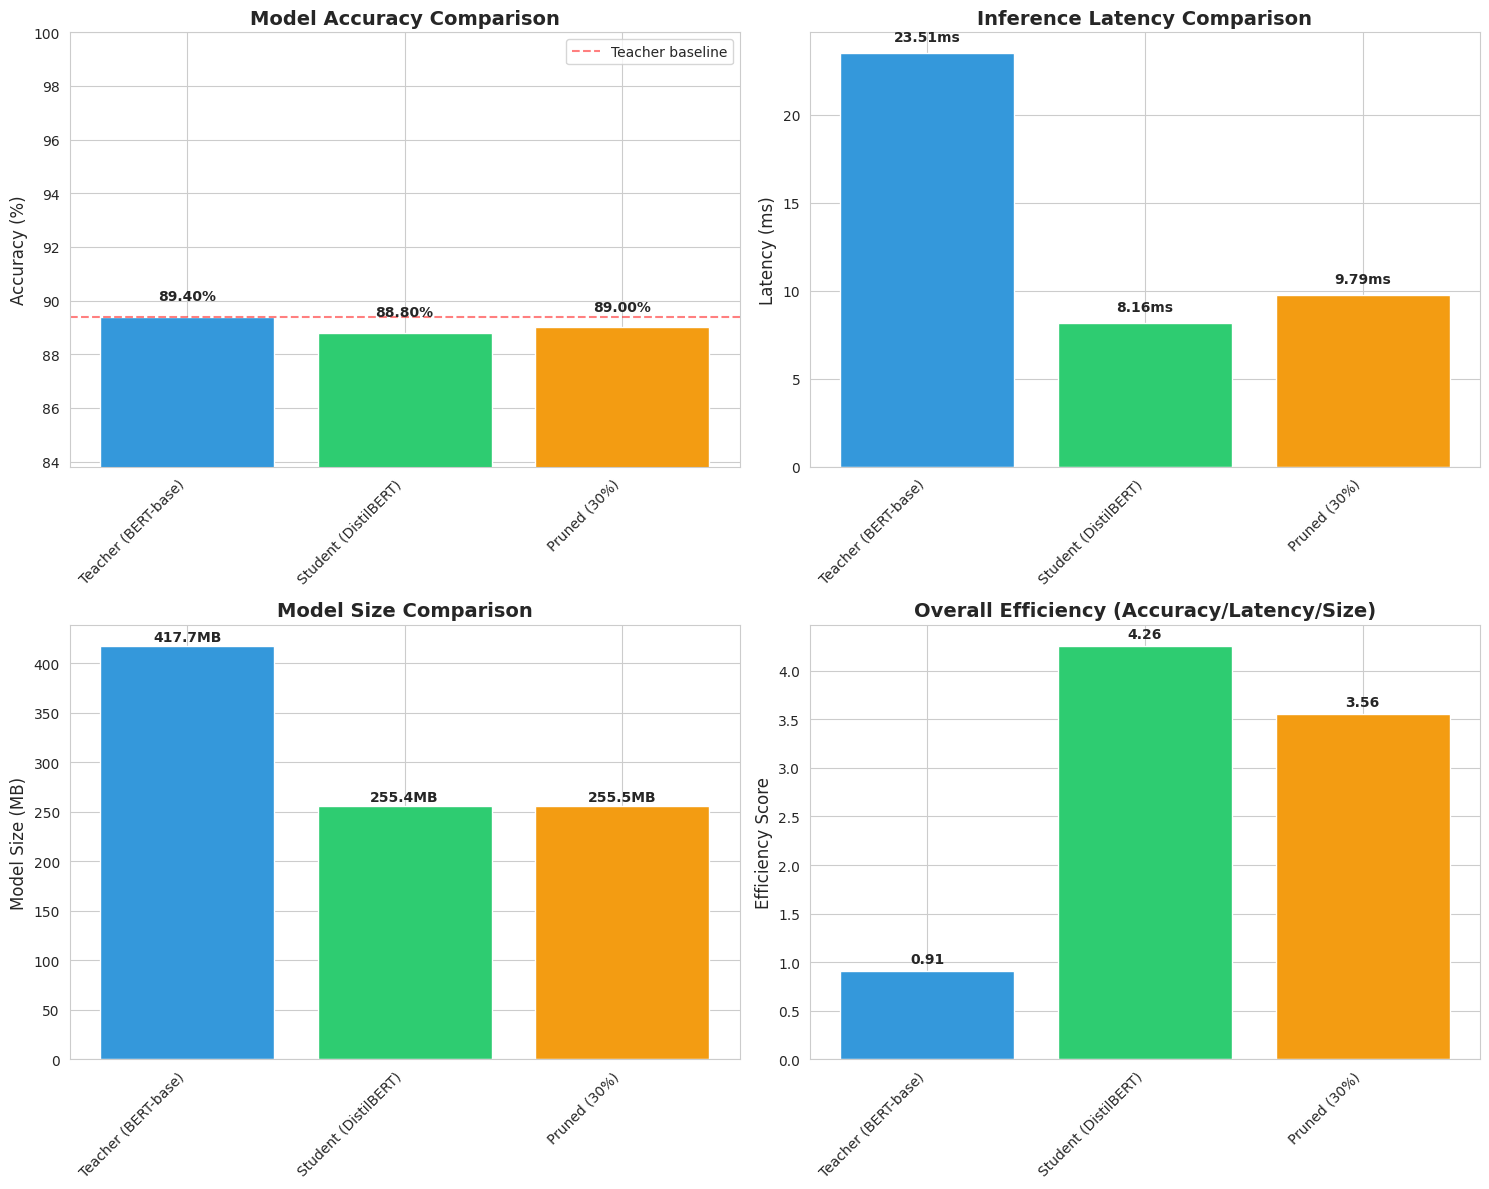

✅ Results saved to /content/benchmark_results.csv

🎉 BENCHMARKING COMPLETE!


In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
import torch
import os
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# ============================================
# 9. Benchmarking: Accuracy, Latency, and Model Size
# ============================================

print("="*70)
print("🔬 COMPREHENSIVE MODEL BENCHMARKING")
print("="*70)

# Configuration
BENCHMARK_SAMPLES = 100  # Number of samples to benchmark latency
BATCH_SIZE = 1  # Use batch size 1 for latency measurement

# ============================================
# Helper Functions
# ============================================

def get_model_size(path):
    """Get model size in MB"""
    if os.path.exists(path):
        return os.path.getsize(path) / (1024 * 1024)
    return None

def measure_accuracy(model, dataloader, device):
    """Measure model accuracy"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    return correct / total if total > 0 else 0

def measure_latency(model, dataloader, device, num_samples=100):
    """Measure average inference latency"""
    model.eval()
    latencies = []

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_samples:
                break

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Warm-up (first inference is often slower)
            if i == 0:
                _ = model(input_ids=input_ids, attention_mask=attention_mask)
                continue

            # Measure latency
            start_time = time.time()
            _ = model(input_ids=input_ids, attention_mask=attention_mask)

            # Synchronize for accurate GPU timing
            if device.type == 'cuda':
                torch.cuda.synchronize()

            end_time = time.time()
            latencies.append((end_time - start_time) * 1000)  # Convert to ms

    return {
        'mean': np.mean(latencies),
        'median': np.median(latencies),
        'std': np.std(latencies),
        'min': np.min(latencies),
        'max': np.max(latencies)
    }

def count_parameters(model):
    """Count total and trainable parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# ============================================
# Prepare Datasets
# ============================================

# Use validation set for accuracy (test set has no labels)
val_loader_full = DataLoader(val_dataset, batch_size=32, shuffle=False)
val_loader_single = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n📊 Using {len(val_dataset)} validation samples for accuracy")
print(f"⏱️  Using {BENCHMARK_SAMPLES} samples for latency measurement\n")

# ============================================
# Benchmark Models
# ============================================

results = []

# ============================================
# 1. Teacher Model (BERT-base)
# ============================================
try:
    print("1️⃣  Benchmarking Teacher Model (BERT-base)...")

    teacher_model = AutoModelForSequenceClassification.from_pretrained("/content/models/teacher")
    teacher_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    teacher_model = teacher_model.to(teacher_device)

    # Accuracy
    teacher_acc = measure_accuracy(teacher_model, val_loader_full, teacher_device)

    # Latency
    teacher_latency = measure_latency(teacher_model, val_loader_single, teacher_device, BENCHMARK_SAMPLES)

    # Model size
    teacher_size_paths = [
        "/content/models/teacher/pytorch_model.bin",
        "/content/models/teacher/model.safetensors"
    ]
    teacher_size = None
    for path in teacher_size_paths:
        if os.path.exists(path):
            teacher_size = get_model_size(path)
            break

    # Parameter count
    teacher_total_params, teacher_trainable_params = count_parameters(teacher_model)

    results.append({
        'Model': 'Teacher (BERT-base)',
        'Accuracy': teacher_acc,
        'Latency (ms)': teacher_latency['mean'],
        'Latency Std': teacher_latency['std'],
        'Model Size (MB)': teacher_size,
        'Parameters (M)': teacher_total_params / 1e6,
        'Device': str(teacher_device)
    })

    print(f"   ✅ Accuracy: {teacher_acc:.4f}")
    print(f"   ⏱️  Latency: {teacher_latency['mean']:.2f} ± {teacher_latency['std']:.2f} ms")
    print(f"   💾 Size: {teacher_size:.2f} MB" if teacher_size else "   💾 Size: N/A")
    print(f"   🔢 Parameters: {teacher_total_params / 1e6:.2f}M\n")

except Exception as e:
    print(f"   ❌ Error: {e}\n")

# ============================================
# 2. Student Model (DistilBERT)
# ============================================
try:
    print("2️⃣  Benchmarking Student Model (DistilBERT)...")

    student_model = AutoModelForSequenceClassification.from_pretrained("/content/models/student")
    student_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    student_model = student_model.to(student_device)

    # Accuracy
    student_acc = measure_accuracy(student_model, val_loader_full, student_device)

    # Latency
    student_latency = measure_latency(student_model, val_loader_single, student_device, BENCHMARK_SAMPLES)

    # Model size
    student_size_paths = [
        "/content/models/student/pytorch_model.bin",
        "/content/models/student/model.safetensors"
    ]
    student_size = None
    for path in student_size_paths:
        if os.path.exists(path):
            student_size = get_model_size(path)
            break

    # Parameter count
    student_total_params, student_trainable_params = count_parameters(student_model)

    results.append({
        'Model': 'Student (DistilBERT)',
        'Accuracy': student_acc,
        'Latency (ms)': student_latency['mean'],
        'Latency Std': student_latency['std'],
        'Model Size (MB)': student_size,
        'Parameters (M)': student_total_params / 1e6,
        'Device': str(student_device)
    })

    print(f"   ✅ Accuracy: {student_acc:.4f}")
    print(f"   ⏱️  Latency: {student_latency['mean']:.2f} ± {student_latency['std']:.2f} ms")
    print(f"   💾 Size: {student_size:.2f} MB" if student_size else "   💾 Size: N/A")
    print(f"   🔢 Parameters: {student_total_params / 1e6:.2f}M\n")

except Exception as e:
    print(f"   ❌ Error: {e}\n")

# ============================================
# 3. Pruned Model
# ============================================
try:
    print("3️⃣  Benchmarking Pruned Model...")

    # Try loading full pruned model
    try:
        pruned_model = torch.load("/content/models/pruned/pruned_model_full.pt")
    except:
        pruned_model = AutoModelForSequenceClassification.from_pretrained("/content/models/student")
        pruned_model.load_state_dict(torch.load("/content/models/pruned/pruned_model.pt"))

    pruned_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pruned_model = pruned_model.to(pruned_device)

    # Accuracy
    pruned_acc = measure_accuracy(pruned_model, val_loader_full, pruned_device)

    # Latency
    pruned_latency = measure_latency(pruned_model, val_loader_single, pruned_device, BENCHMARK_SAMPLES)

    # Model size
    pruned_size = get_model_size("/content/models/pruned/pruned_model.pt")
    if pruned_size is None:
        pruned_size = get_model_size("/content/models/pruned/pruned_model_full.pt")

    # Parameter count
    pruned_total_params, pruned_trainable_params = count_parameters(pruned_model)

    results.append({
        'Model': 'Pruned (30%)',
        'Accuracy': pruned_acc,
        'Latency (ms)': pruned_latency['mean'],
        'Latency Std': pruned_latency['std'],
        'Model Size (MB)': pruned_size,
        'Parameters (M)': pruned_total_params / 1e6,
        'Device': str(pruned_device)
    })

    print(f"   ✅ Accuracy: {pruned_acc:.4f}")
    print(f"   ⏱️  Latency: {pruned_latency['mean']:.2f} ± {pruned_latency['std']:.2f} ms")
    print(f"   💾 Size: {pruned_size:.2f} MB" if pruned_size else "   💾 Size: N/A")
    print(f"   🔢 Parameters: {pruned_total_params / 1e6:.2f}M\n")

except Exception as e:
    print(f"   ❌ Error: {e}\n")

# ============================================
# 4. Quantized Model
# ============================================
try:
    print("4️⃣  Benchmarking Quantized Model (INT8)...")

    quantized_model = torch.load("/content/models/quantized/quantized_model_full.pt")
    quantized_device = torch.device('cpu')  # Quantized models run on CPU
    quantized_model = quantized_model.to(quantized_device)

    # Accuracy
    quantized_acc = measure_accuracy(quantized_model, val_loader_full, quantized_device)

    # Latency
    quantized_latency = measure_latency(quantized_model, val_loader_single, quantized_device, BENCHMARK_SAMPLES)

    # Model size
    quantized_size = get_model_size("/content/models/quantized/quantized_model_full.pt")

    # Parameter count
    quantized_total_params, quantized_trainable_params = count_parameters(quantized_model)

    results.append({
        'Model': 'Quantized (INT8)',
        'Accuracy': quantized_acc,
        'Latency (ms)': quantized_latency['mean'],
        'Latency Std': quantized_latency['std'],
        'Model Size (MB)': quantized_size,
        'Parameters (M)': quantized_total_params / 1e6,
        'Device': str(quantized_device)
    })

    print(f"   ✅ Accuracy: {quantized_acc:.4f}")
    print(f"   ⏱️  Latency: {quantized_latency['mean']:.2f} ± {quantized_latency['std']:.2f} ms")
    print(f"   💾 Size: {quantized_size:.2f} MB" if quantized_size else "   💾 Size: N/A")
    print(f"   🔢 Parameters: {quantized_total_params / 1e6:.2f}M\n")

except Exception as e:
    print(f"   ❌ Error: {e}\n")

# ============================================
# 5. ONNX Model
# ============================================
try:
    print("5️⃣  Benchmarking ONNX Model...")

    from optimum.onnxruntime import ORTModelForSequenceClassification

    onnx_model = ORTModelForSequenceClassification.from_pretrained("/content/models/onnx")
    onnx_device = torch.device('cpu')  # ONNX models run on CPU

    # Accuracy
    onnx_acc = measure_accuracy(onnx_model, val_loader_full, onnx_device)

    # Latency
    onnx_latency = measure_latency(onnx_model, val_loader_single, onnx_device, BENCHMARK_SAMPLES)

    # Model size
    onnx_size = get_model_size("/content/models/onnx/model.onnx")

    # Parameter count (approximate)
    onnx_total_params = student_total_params if 'student_total_params' in locals() else None

    results.append({
        'Model': 'ONNX',
        'Accuracy': onnx_acc,
        'Latency (ms)': onnx_latency['mean'],
        'Latency Std': onnx_latency['std'],
        'Model Size (MB)': onnx_size,
        'Parameters (M)': onnx_total_params / 1e6 if onnx_total_params else None,
        'Device': 'CPU (ONNX Runtime)'
    })

    print(f"   ✅ Accuracy: {onnx_acc:.4f}")
    print(f"   ⏱️  Latency: {onnx_latency['mean']:.2f} ± {onnx_latency['std']:.2f} ms")
    print(f"   💾 Size: {onnx_size:.2f} MB" if onnx_size else "   💾 Size: N/A")
    if onnx_total_params:
        print(f"   🔢 Parameters: {onnx_total_params / 1e6:.2f}M\n")
    else:
        print(f"   🔢 Parameters: N/A\n")

except Exception as e:
    print(f"   ❌ Error: {e}\n")

# ============================================
# Results Summary
# ============================================

print("="*70)
print("📊 BENCHMARK RESULTS SUMMARY")
print("="*70)

# Create DataFrame
df_results = pd.DataFrame(results)

# Display table
print("\n" + df_results.to_string(index=False))

# Calculate improvements
if len(results) >= 2:
    print("\n" + "="*70)
    print("📈 IMPROVEMENTS vs TEACHER MODEL")
    print("="*70)

    teacher_data = results[0]

    for i, result in enumerate(results[1:], 1):
        print(f"\n{result['Model']}:")

        # Accuracy difference
        acc_diff = result['Accuracy'] - teacher_data['Accuracy']
        print(f"  • Accuracy: {result['Accuracy']:.4f} ({acc_diff:+.4f}, {acc_diff*100:+.2f}%)")

        # Latency speedup
        if result['Latency (ms)'] and teacher_data['Latency (ms)']:
            speedup = teacher_data['Latency (ms)'] / result['Latency (ms)']
            print(f"  • Latency: {result['Latency (ms)']:.2f} ms ({speedup:.2f}x faster)" if speedup > 1
                  else f"  • Latency: {result['Latency (ms)']:.2f} ms ({1/speedup:.2f}x slower)")

        # Size reduction
        if result['Model Size (MB)'] and teacher_data['Model Size (MB)']:
            size_reduction = (1 - result['Model Size (MB)'] / teacher_data['Model Size (MB)']) * 100
            print(f"  • Size: {result['Model Size (MB)']:.2f} MB ({size_reduction:.1f}% reduction)")

# ============================================
# Visualization
# ============================================

print("\n" + "="*70)
print("📊 GENERATING VISUALIZATIONS")
print("="*70)

# Set style
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Accuracy Comparison
ax1 = axes[0, 0]
models = [r['Model'] for r in results]
accuracies = [r['Accuracy'] * 100 for r in results]
bars1 = ax1.bar(models, accuracies, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6'][:len(models)])
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([min(accuracies) - 5, 100])
ax1.axhline(y=accuracies[0], color='r', linestyle='--', alpha=0.5, label='Teacher baseline')
for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{acc:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
ax1.legend()
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. Latency Comparison
ax2 = axes[0, 1]
latencies = [r['Latency (ms)'] for r in results if r['Latency (ms)']]
latency_models = [r['Model'] for r in results if r['Latency (ms)']]
bars2 = ax2.bar(latency_models, latencies, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6'][:len(latencies)])
ax2.set_ylabel('Latency (ms)', fontsize=12)
ax2.set_title('Inference Latency Comparison', fontsize=14, fontweight='bold')
for i, (bar, lat) in enumerate(zip(bars2, latencies)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{lat:.2f}ms', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Model Size Comparison
ax3 = axes[1, 0]
sizes = [r['Model Size (MB)'] for r in results if r['Model Size (MB)']]
size_models = [r['Model'] for r in results if r['Model Size (MB)']]
bars3 = ax3.bar(size_models, sizes, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6'][:len(sizes)])
ax3.set_ylabel('Model Size (MB)', fontsize=12)
ax3.set_title('Model Size Comparison', fontsize=14, fontweight='bold')
for i, (bar, size) in enumerate(zip(bars3, sizes)):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f'{size:.1f}MB', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4. Efficiency Score (Accuracy / Latency * Size)
ax4 = axes[1, 1]
efficiency_scores = []
efficiency_models = []
for r in results:
    if r['Accuracy'] and r['Latency (ms)'] and r['Model Size (MB)']:
        # Higher accuracy, lower latency, smaller size = better
        score = (r['Accuracy'] * 100) / (r['Latency (ms)'] * r['Model Size (MB)'] / 100)
        efficiency_scores.append(score)
        efficiency_models.append(r['Model'])

if efficiency_scores:
    bars4 = ax4.bar(efficiency_models, efficiency_scores,
                    color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6'][:len(efficiency_scores)])
    ax4.set_ylabel('Efficiency Score', fontsize=12)
    ax4.set_title('Overall Efficiency (Accuracy/Latency/Size)', fontsize=14, fontweight='bold')
    for i, (bar, score) in enumerate(zip(bars4, efficiency_scores)):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                 f'{score:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('/content/benchmark_results.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved to /content/benchmark_results.png")
plt.show()

# ============================================
# Save Results to CSV
# ============================================

df_results.to_csv('/content/benchmark_results.csv', index=False)
print("✅ Results saved to /content/benchmark_results.csv")

print("\n" + "="*70)
print("🎉 BENCHMARKING COMPLETE!")
print("="*70)

In [ ]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Model Size Comparison
axes[0, 0].bar(results_df['Model'], results_df['Size (MB)'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
axes[0, 0].set_ylabel('Model Size (MB)')
axes[0, 0].set_title('Model Size Comparison')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Accuracy Comparison
axes[0, 1].plot(results_df['Model'], results_df['Accuracy'], marker='o', linewidth=2, markersize=8, color='green')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Accuracy Across Compression Stages')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].set_ylim([0.8, 1.0])

# 3. Latency Comparison
axes[1, 0].bar(results_df['Model'], results_df['Latency (ms)'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
axes[1, 0].set_ylabel('Latency (ms)')
axes[1, 0].set_title('Inference Latency Comparison')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Compression vs Accuracy Trade-off
axes[1, 1].scatter(results_df['Compression (%)'], results_df['Accuracy'],
                   s=200, alpha=0.6, c=results_df['Compression (%)'], cmap='viridis')
for i, model in enumerate(results_df['Model']):
    axes[1, 1].annotate(model, (results_df['Compression (%)'].iloc[i], results_df['Accuracy'].iloc[i]),
                       fontsize=8, ha='left')
axes[1, 1].set_xlabel('Compression (%)')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Compression vs Accuracy Trade-off')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/models/compression_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved to /content/models/compression_analysis.png")


## 11. ONNX Runtime Inference Demo (CPU/ARM Simulation)


In [ ]:
from onnxruntime import InferenceSession
import numpy as np

# Demo inference using ONNX Runtime (CPU)
if os.path.exists(onnx_quantized_path):
    model_path = onnx_quantized_path
elif os.path.exists(onnx_model_path):
    model_path = onnx_model_path
else:
    print("⚠️ No ONNX model found for inference demo")
    model_path = None

if model_path:
    print("🚀 Running ONNX Runtime Inference Demo (CPU)...")
    print("\nThis simulates deployment on ARM/CPU edge devices\n")

    # Create inference session (CPU provider)
    session = InferenceSession(model_path, providers=['CPUExecutionProvider'])

    # Test samples
    test_sentences = [
        "This movie is absolutely fantastic and well-made!",
        "I hated this film, it was terrible.",
        "The plot was okay, nothing special.",
        "An amazing performance by the cast, highly recommended!"
    ]

    print("📝 Test Sentences:\n")
    for i, sentence in enumerate(test_sentences, 1):
        # Tokenize
        inputs = student_tokenizer(sentence, return_tensors="np", truncation=True,
                                  padding="max_length", max_length=128)

        input_ids = inputs['input_ids'].astype(np.int64)
        attention_mask = inputs['attention_mask'].astype(np.int64)

        ort_inputs = {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

        # Inference
        start_time = time.time()
        outputs = session.run(None, ort_inputs)
        end_time = time.time()

        latency_ms = (end_time - start_time) * 1000

        # Get prediction
        logits = outputs[0]
        probs = torch.softmax(torch.tensor(logits), dim=-1)
        predicted_class = np.argmax(logits, axis=1)[0]
        sentiment = "Positive" if predicted_class == 1 else "Negative"
        confidence = probs[0][predicted_class].item() * 100

        print(f"{i}. Sentence: '{sentence}'")
        print(f"   Prediction: {sentiment} (confidence: {confidence:.1f}%)")
        print(f"   Latency: {latency_ms:.2f} ms\n")

    print("✅ ONNX Runtime inference demo completed!")
    print(f"\n💾 Model path: {model_path}")
    print(f"📦 Model size: {get_model_size(model_path):.2f} MB")
    print(f"⚡ Ready for deployment on ARM/CPU devices!")


## 12. Summary and Final Results Table


In [ ]:
print("\n" + "="*100)
print(" " * 30 + "FINAL COMPRESSION RESULTS")
print("="*100)

# Display formatted table
print("\n")
print(results_df.to_string(index=False))

print("\n" + "="*100)
print("\n📊 KEY INSIGHTS:\n")
print(f"1. Model Size Reduction: {results_df['Compression (%)'].max():.1f}% compression achieved")
print(f"2. Accuracy Retention: {results_df['Accuracy'].iloc[-1]:.4f} (vs {results_df['Accuracy'].iloc[0]:.4f} baseline)")
print(f"3. Latency Improvement: {results_df['Latency (ms)'].iloc[0]:.2f}ms → {results_df['Latency (ms)'].iloc[-1]:.2f}ms")
print(f"4. Speed-up Factor: {results_df['Latency (ms)'].iloc[0] / results_df['Latency (ms)'].iloc[-1]:.2f}x faster")

print("\n✅ All models saved in /content/models/")
print("   - Teacher model: /content/models/teacher/")
print("   - Student model: /content/models/student/")
print("   - Pruned model: /content/models/pruned/")
print("   - Quantized model: /content/models/quantized/")
print("   - ONNX models: /content/models/onnx/")

print("\n" + "="*100)
print("🎉 LLM Compression Pipeline Complete! Ready for Edge Deployment! 🚀")
print("="*100)
